# LSE ST451: Bayesian Machine Learning
## Author: Kostas Kalogeropoulos

## Week 8: Markov Chain Monte Carlo / Bayesian Sparse Linear Regression

Topics covered 
 - Sampling from the posterior using the Gibbs Sampler in Python
 - Presenting the output of a Markov Chain Monte Carlo (MCMC) ouput 
 - Using Hamiltonian MCMC to sample from the posterior using Stan
 - Presenting MCMC output in Stan
 - Bayesian Sparse Linear Regression with the *horseshoe* prior

We will use standard Python libraries (that have been used before). For Stan we will continue in RStudio.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

### Gibbs sampler

We will first code a Gibbs Sampler for the model where $y=(y_1,\dots,y_n)$ are independent $N(\mu,
\sigma^2)$ random variables with both $\mu$ and $\sigma^2$ unknown.

We will assign the $N(0,\omega^2)$ prior on $\mu$ and the $IGamma(\alpha,\beta)$ prior on $\sigma^2$.

Then we get that 

$$
\mu |y,\sigma^2 \sim N\left(\frac{\omega^2\bar{y}}{\omega^2 + \sigma^2/n},\frac{\omega^2 \sigma^2/n}{\omega^2 + \sigma^2/n}\right)
$$
and
$$
\sigma^2|y,\mu \sim IGamma (n/2+\alpha, \beta+\frac{\sum_{i=1}^{n}(y_i-\bar{y})^2+n(\bar{y}-\mu)^2}{2})
$$

#### First we simulate data

In [2]:
#Simulate data to check the Gibbs sampler
n = 100 #sample size
sigma_true = 2
sigma2_true = sigma_true**2
mu_true = 5
np.random.seed(4)
y = mu_true + np.random.randn(n)*sigma_true
ybar = np.mean(y)
S2 = np.sum((y-ybar)**2)
print('data:',y)
print('sample mean:',ybar)
print('sample variance:',S2/(n-1))

data: [5.10112341 5.99990267 3.00818214 6.38719702 4.16339696 1.83084553
 3.70458647 6.19715035 5.66450007 2.70504673 6.23733938 4.82402614
 5.85014479 5.66450629 2.68636748 5.70199431 3.78622543 8.09395866
 6.44668322 5.09227113 3.03401669 5.10886548 5.31978587 2.58210368
 9.44672043 5.78859043 8.38471543 2.77437569 8.27149508 2.27806882
 3.69754833 6.08490262 5.09601249 0.28385273 2.78883191 6.67567271
 9.17574174 6.82968192 4.44759329 6.5930238  2.71240286 6.01983957
 2.30507941 4.9812798  4.73859072 6.60417323 4.39407207 7.40400518
 4.60650944 6.6730574  6.57320457 1.31824827 5.07509497 5.0718561
 3.44252015 5.35882143 2.08893135 6.11237045 6.01955771 5.60089109
 9.95316832 5.70468679 5.134942   3.5354706  5.59428242 3.0764464
 7.54363723 3.70471093 5.31693907 8.98016603 7.32837512 5.48532032
 7.75984019 4.89088259 6.5904679  5.03817992 3.18912373 5.86054266
 6.86930013 4.30779626 2.80575623 3.94360786 0.24044945 3.78463262
 2.84941982 9.04481013 3.87024941 1.9141419  6.74168356 4.

#### Now we run the Gibbs sampler 

In [5]:
N = 10000 # number of iterations

#create object mus and sigma2s to store the Markov chain samples, 
#with $\pi(\theta,\sigma^2|y)$ as stationary distribution
out_mu = np.zeros(N)
out_sigma2 = np.zeros(N)

#Set prior parameters
omega2 = 1000
alpha = 0.1
beta = 0.1

#Set initial values for mu and sigma2
mu = -0
sigma2 = 10

for i in range(N):
    #Store current value of the chain (mu,sigma2)
    out_mu[i] = mu
    out_sigma2[i] = sigma2
    
    #Draw mu given y and sigma2
    denominator = omega2 + (sigma2/n)
    M = omega2*ybar/denominator          #Mean of the full conditional of mu
    V = omega2*(sigma2/n)/denominator    #Variance of the full conditional of mu 
    mu = M + np.sqrt(V)*np.random.randn(1)  #Draw from the full conditional of mu
    
    #Draw sigma2 given y and mu
    A = 0.5*n + alpha                  #A parameter of the full conditional of sigma2
    B = beta + 0.5*(S2+ n*((ybar-mu)**2)) #B parameter of the full conditional of sigma2
    sigma2 = 1/np.random.gamma(A, 1/B, 1)

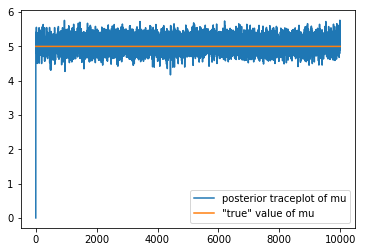

In [6]:
plt.plot(out_mu,label='posterior traceplot of mu')
plt.plot(np.ones(N)*mu_true,label='"true" value of mu')
plt.legend()

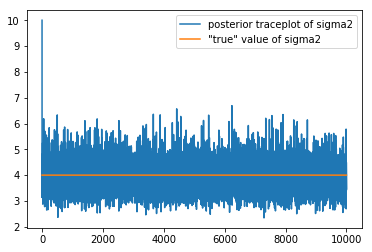

In [7]:
plt.plot(out_sigma2,label='posterior traceplot of sigma2')
plt.plot(np.ones(N)*sigma2_true,label='"true" value of sigma2')
plt.legend()

In [8]:
#present the output via a pandas data frame
mmu = np.mean(out_mu)
medmu = np.median(out_mu)
pctmu = np.percentile(out_mu,(2.5,97.5))
msig = np.mean(out_sigma2)
medsig = np.median(out_sigma2)
pctsig = np.percentile(out_sigma2,(2.5,97.5))
results = np.array([[mmu,medmu,pctmu[0],pctmu[1]],[msig,medsig,pctsig[0],pctsig[1]]]).round(3)
col = ['Posterior mean','Posterior median','Posterior 2.5% point','Posterior 97.5% point']
ind = ['mu','sigma2']
results = pd.DataFrame(results,columns = col,index=ind)
results

,Posterior mean,Posterior median,Posterior 2.5% point,Posterior 97.5% point
mu,5.069,5.073,4.675,5.457
sigma2,3.903,3.848,2.946,5.164


### Activity 1

Repeat for the model below

$$
y_i\sim \text{Poisson}(\mu), \;\;i=1,...,N,
$$
with priors 
$$
\mu \sim \text{Gamma}(2,\beta),\;\;
\beta \sim \text{Exponential}(1)
$$

It can be shown (good exercise) that the full conditionals for $\mu,\beta$ are 

$$
\mu| y,\beta \;\sim\;\text{Gamma}(2 + \sum_i y_i,n+\beta)
$$
$$
\beta|y,\mu\;\sim \;\text{Gamma}(3,1+\mu)
$$

Put your code below

### Bayesian Sparse Linear Regression

We will illustrate several Bayesian (or not) approaches to handle sparsity in linear regression on the diabetes dataset.

Some info on the data is given below:

 - 442 diabetes patients
 - 10 main variables, x_1,...,x_{10} : age, gender, body mass index, average blood pressure (map), and six blood serum measurements (tc, ldl, hdl, tch, ltg, glu)
 - 45 interactions of the form xjxk
 - 9 quadratic effects of the form x_j^2 (gender is binary, so x^2=x_2^2)
 - measure of disease progression taken one year later, $y$

We have a total of $p=64$ variables that we might use to predict $y$. It seems plausible that a subset of the variables will reliably predict $y$

First we load the `diabetes.data.txt` file to get y

In [ ]:
diabetesY = pd.read_csv('diabetes.data.txt',sep="\t")
diabetesY.head()

In [ ]:
y = diabetesY['Y']
y = (y - np.mean(y))/np.std(y)
y.shape

Then we load the `data64.txt` file to get X

In [ ]:
diabetesX = pd.read_csv('data64.txt', sep="\t")
X = diabetesX.values
X = (X - np.mean(X,axis=0))/np.std(X,axis=0)
X.shape

Split the data into train and test datasets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100/442, random_state=5)
X_test.shape

Now we can start fitting models. We start with the **null model** (no covariates) and the **OLS** (all covariates)

In [ ]:
# Null model use the sample mean of y
print('null: ',np.sum((y_test - np.mean(y_train))**2) / len(y_test))

# OLS 
linreg = LinearRegression(fit_intercept=False,normalize=False)
linreg.fit(X_train,y_train)
y_pred = linreg.predict(X_test)
print('OLS: ',np.sum((y_test - y_pred)**2) / len(y_test))

Next we apply **Ridge** and **Lasso** regression. For each of these, we search for the penalty parameter that minimises the MSE and report that.

In [ ]:
# Ridge
Lambdas = np.linspace(0.5,50,100)
MSEs = np.zeros(100)
for i in range(100):
    ridgereg = Ridge(fit_intercept=False,normalize=False,alpha=Lambdas[i])
    ridgereg.fit(X_train,y_train)
    y_pred = ridgereg.predict(X_test)
    MSEs[i] = np.sum((y_test - y_pred)**2) / len(y_test)
print('Ridge: ',np.min(MSEs),' lambda: ',Lambdas[np.argmin(MSEs)])

In [ ]:
# Lasso
Lambdas = np.linspace(1e-2,1,100)
MSEs = np.zeros(100)
for i in range(100):
    lassoreg = Lasso(fit_intercept=False,normalize=False,alpha=Lambdas[i])
    lassoreg.fit(X_train,y_train)
    y_pred = lassoreg.predict(X_test)
    MSEs[i] = np.sum((y_test - y_pred)**2) / len(y_test)
print('Lasso: ',np.min(MSEs),' lambda: ',Lambdas[np.argmin(MSEs)])

Finally we will save all the data to load them in RStudio and work with Stan

In [ ]:
np.savetxt('X_train.csv', X_train, delimiter=',')
np.savetxt('X_test.csv', X_test, delimiter=',')
np.savetxt('y_train.csv', y_train, delimiter=',')
np.savetxt('y_test.csv', y_test, delimiter=',')